In this notebook, we'll examine how the accuracy of the AVM's gradient is dependent on the design parameter resolution. In theory, this shouldn't be the case.

We can at least assume that the problem is with our basis interpolator responsible for transforming our design variables to permittivity values throughout the simulation.

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt
mp.quiet(quietval=True)

Using MPI version 3.1, 1 processes


First let's run simulate the same waveguide bend as the tutorials. We'll match each design parameter to a design pixel. In other words, the design variable resolution is the same as the simulation grid resolution.

In [2]:
resolution = 20

design_region_width = 1
design_region_height = 1
design_region_resolution = resolution

Nx = design_region_resolution * design_region_width
Ny = design_region_resolution * design_region_height

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]
fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]
seed = 24
np.random.seed(seed)

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height, 0))
rho_vector = 11*np.random.rand(Nx*Ny) + 1
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,Nx=Nx,Ny=Ny,rho_vector=rho_vector)

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=mp.Medium(index=3.45), size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=design_variables.func()) # design region
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)

TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(x=2)),mode=1)
ob_list = [TE0]

def J(alpha):
    return npa.abs(alpha) ** 2

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_variables=[design_variables],
    fcen=fcen,
    df = 0,
    nf = 1,
    decay_fields=[mp.Ez]
)

f0, dJ_deps, dg = opt()

g_adjoint = design_variables.get_basis_vjp(dJ_deps,dg)

db = 1e-3
choose = 20
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)

Starting forward run...
Starting adjoint run...
Calculating gradient...


We'll plot results

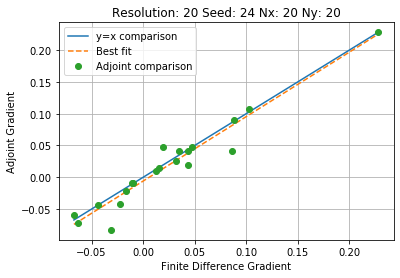

In [3]:
(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)

min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit')
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {} Seed: {} Nx: {} Ny: {}'.format(resolution,seed,Nx,Ny))
plt.legend()
plt.grid(True)
plt.show()

And we see good agreement between the adjoint and finite difference gradients.

Typically we want to have a higher density of design parameters. So for every meep grid pixel, we'll allocate 4 design parameters:

In [4]:
resolution = 20

design_region_width = 1
design_region_height = 1
design_region_resolution = 4*resolution

Nx = design_region_resolution * design_region_width
Ny = design_region_resolution * design_region_height

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]
fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]
seed = 24
np.random.seed(seed)

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height, 0))
rho_vector = 11*np.random.rand(Nx*Ny) + 1
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,Nx=Nx,Ny=Ny,rho_vector=rho_vector)

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=mp.Medium(index=3.45), size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=design_variables.func()) # design region
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)

TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(x=2)),mode=1)
ob_list = [TE0]

def J(alpha):
    return npa.abs(alpha) ** 2

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_variables=[design_variables],
    fcen=fcen,
    df = 0,
    nf = 1,
    decay_fields=[mp.Ez]
)

f0, dJ_deps, dg = opt()

g_adjoint = design_variables.get_basis_vjp(dJ_deps,dg)

db = 1e-3
choose = 20
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)

Starting forward run...
Starting adjoint run...
Calculating gradient...


We can once again plot the results:

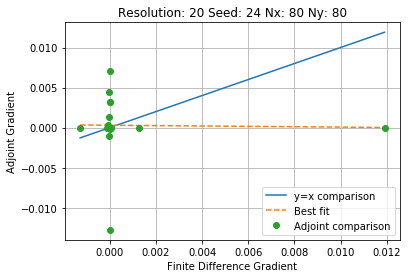

In [5]:
(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)

min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit')
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {} Seed: {} Nx: {} Ny: {}'.format(resolution,seed,Nx,Ny))
plt.legend()
plt.grid(True)
plt.show()

And we see that the results do not align. Granted, the gradients are much smaller, but there is still quite a bit of swing.

To double check, we'll decrease our resolution such that there are four meep pixels mapping to one design parameter:

In [6]:
resolution = 20

design_region_width = 1
design_region_height = 1
design_region_resolution = int(0.25*resolution)

Nx = design_region_resolution * design_region_width
Ny = design_region_resolution * design_region_height

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]
fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]
seed = 24
np.random.seed(seed)

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height, 0))
rho_vector = 11*np.random.rand(Nx*Ny) + 1
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,Nx=Nx,Ny=Ny,rho_vector=rho_vector)

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=mp.Medium(index=3.45), size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=design_variables.func()) # design region
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)

TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(x=2)),mode=1)
ob_list = [TE0]

def J(alpha):
    return npa.abs(alpha) ** 2

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_variables=[design_variables],
    fcen=fcen,
    df = 0,
    nf = 1,
    decay_fields=[mp.Ez]
)

f0, dJ_deps, dg = opt()

g_adjoint = design_variables.get_basis_vjp(dJ_deps,dg)

db = 1e-3
choose = 20
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)

Starting forward run...
Starting adjoint run...
Calculating gradient...


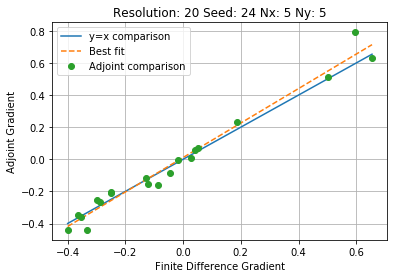

In [7]:
(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)

min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit')
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {} Seed: {} Nx: {} Ny: {}'.format(resolution,seed,Nx,Ny))
plt.legend()
plt.grid(True)
plt.show()

We see that the results align well. It's clear that we only have problems as the design parameter resolution exceeds the simulation resolution.

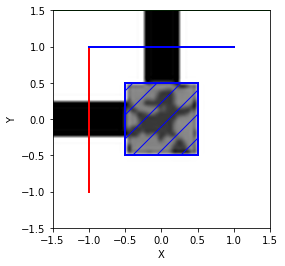

In [8]:
from autograd import grad, jacobian
resolution = 20

design_region_width = 1
design_region_height = 1
design_region_resolution = int(4*resolution)

Nx = design_region_resolution * design_region_width
Ny = design_region_resolution * design_region_height

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]
fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]
seed = 24
np.random.seed(seed)

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height, 0))
rho_vector = np.random.rand(Nx*Ny)
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,Nx=Nx,Ny=Ny,rho_vector=rho_vector)

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=mp.Medium(index=3.45), size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=design_variables.func()) # design region
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)

TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(x=2)),mode=1)
ob_list = [TE0]

def J(alpha):
    return npa.abs(alpha) ** 2

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_variables=[design_variables],
    fcen=fcen,
    df = 0,
    nf = 1,
    decay_fields=[mp.Ez]
)
def material_scaling(x):
    return 11*x + 1
def mapping(x,sigma,delta,beta):
    return material_scaling(mpa.projection_filter(mpa.smoothing_filter(x,sigma,delta,Nx,Ny),sigma,delta,beta))

filter_radius = 0.1
beta = 1
sigma = 5
delta = 0
opt.update_design([mapping(rho_vector,sigma,delta,beta)])
opt.plot2D(True,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.show()

In [9]:
f0, dJ_deps, dg = opt([mapping(rho_vector,beta,sigma,delta)])
dJ_drhobar = np.squeeze(design_variables.get_basis_vjp(dJ_deps,dg))
g_adjoint = jacobian(mapping,0)(dJ_drhobar,sigma,delta,beta)@dJ_drhobar

Starting forward run...
Starting adjoint run...
Calculating gradient...


In [10]:
db = 1e-3
choose = 20
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db,filter=mapping)

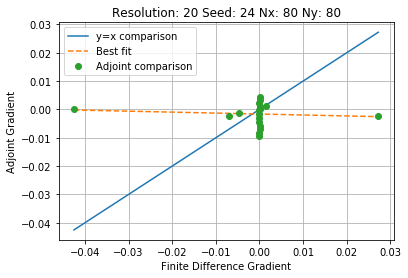

In [11]:
(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)

min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit')
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {} Seed: {} Nx: {} Ny: {}'.format(resolution,seed,Nx,Ny))
plt.legend()
plt.grid(True)
plt.show()